# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np

from src.Inference import Inference
from src.Subspace import Subspace
from src.model import Model
from src.util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'.\example\hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
# my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Text(0, 0.5, 'Y')

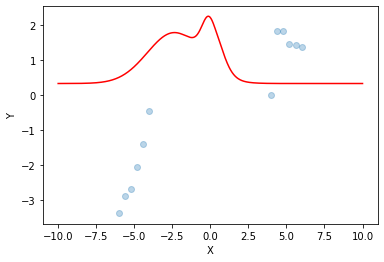

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y')


In [4]:
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture,Sigma_Y=np.array([[2]]))
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [24]:
hmc_tune_params={'step_size':0.01,
                                'leapfrog_steps': 10,
                                'total_samples': 10000,
                                'burn_in': 0.2,
                                'warm_start': False,
                                'thinning_factor': 2,
                                'mom_std': 1,
                                'diagnostic_mode': False}

In [25]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=np.eye(P.shape[0]), w_hat=np.zeros_like(w),  tune_params=hmc_tune_params,
                               Sigma_Z=5)

In [26]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [ ]:
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)#,diagnostic_mode=False)#, step_size=1e-2, leapfrog_steps=1000,
              #total_samples=10000, burn_in=0.1, thinning_factor=2, check_point=200)

HMC 200: accept rate of 100.0 with step size 0.01
HMC 400: accept rate of 100.0 with step size 0.0105
HMC 600: accept rate of 100.0 with step size 0.011025000000000002
HMC 800: accept rate of 99.875 with step size 0.011576250000000003
HMC 1000: accept rate of 99.9 with step size 0.012155062500000004
HMC 1200: accept rate of 99.83333333333333 with step size 0.012762815625000005
HMC 1400: accept rate of 99.85714285714286 with step size 0.013400956406250006
HMC 1600: accept rate of 99.875 with step size 0.014071004226562506
HMC 1800: accept rate of 99.8888888888889 with step size 0.014774554437890632
HMC 200: accept rate of 99.5
HMC 400: accept rate of 99.25
HMC 600: accept rate of 99.33333333333333
HMC 800: accept rate of 99.5
HMC 1000: accept rate of 99.3
HMC 1200: accept rate of 99.41666666666667
HMC 1400: accept rate of 99.35714285714286
HMC 1600: accept rate of 99.375
HMC 1800: accept rate of 99.27777777777777
HMC 2000: accept rate of 99.3
HMC 2200: accept rate of 99.27272727272727
H

In [ ]:

# get posterior z
n_sample = 10
post_sample = my_inference.get_posterior(n_samples=n_sample).reshape(-1, 2)
x_test = np.linspace(-8, 8, 100)
y_test = np.reshape(
    [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
    (n_sample, -1)) \
         + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

In [ ]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test, 0.25, axis=0), np.percentile(y_test, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()